In [1]:
import sys
import os

# bandaid fix for running this notebook in its folder on ROAR
external_folder_path = '../'
sys.path.insert(0, external_folder_path)

from sparktools.sparkhandler import SparkHandler
from dataproc.dataproctools import get_extracted_wet, save_rdd, load_rdd
from pyspark import StorageLevel

We use the spark handler class so we can use a unified spark session across our functions. This essentially just helps us initialize the spark session and stores the session and context within itself

In [2]:
handler = SparkHandler(available_cores=4) # look at the parameters for SparkHandler to increase max memory
ss = handler.get_spark_session()
sc = handler.get_spark_context()

Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/12/10 16:19:33 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


Here we can load in our str data. Do note, `get_extracted_wet` doesn't return the sample size exactly, but an approximate amount based on the wet we use

In [3]:
raw_data = get_extracted_wet(spark_context=sc, approx_sample_size=10000, wet_paths_file="../data/wet.paths")
save_rdd(raw_data, "../saved_intermediates/rawStrRDD", overwrite=True) #

In [4]:
loaded_str_data = load_rdd(spark_context=sc, path_to_load="../saved_intermediates/rawStrRDD")

Typically, processing this code, especially at large scales, takes a lot of time. In order to not recompute every time we run this, we can save this RDD and load it later.

In [5]:
from dataproc.dataproctools import extracted_wet_to_df

In [6]:
df = extracted_wet_to_df(spark_session=ss, extracted_wet_rdd=loaded_str_data)

and if you have pandas to help visualize

In [7]:
filtered = df.filter(((df.tld == '.gov') | (df.tld == '.edu')) & (df.languages == 'eng'))

In [8]:
from pyspark.ml.feature import RegexTokenizer
from pyspark.ml.feature import Tokenizer, StopWordsRemover, CountVectorizer
from pyspark.ml.clustering import LDA
from pyspark.ml import Pipeline

In [9]:
# 1) Tokenize text into tokens
tokenizer = RegexTokenizer(minTokenLength=2, gaps=False, pattern=r"\b[a-zA-Z]+[\d]*(?:[-'][a-zA-Z]+[\d]*)*\b", inputCol="raw_content", outputCol="tokenized")

# 2) Remove stopwords
remover = StopWordsRemover(inputCol="tokenized", outputCol="filtered")

# 3) Convert tokens to term-frequency vectors
cv = CountVectorizer(
    inputCol="filtered",
    outputCol="features",
    vocabSize=5000,
    minDF=1    # keep terms that appear in at least 1 document
)

# 4) LDA model (k = number of topics)
lda = LDA(
    k=12,
    maxIter=10,
    featuresCol="features"
)

# 5) Build pipeline
pipeline = Pipeline(stages=[tokenizer, remover, cv, lda])

pipeline

Pipeline_c57f6644a424

In [10]:
model = pipeline.fit(filtered)

# Extract the CV and LDA sub-models
cv_model = model.stages[2]
lda_model = model.stages[3]

vocab = cv_model.vocabulary
len(vocab), vocab[:20]

25/12/10 16:20:36 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS


(5000,
 ['volume',
  'issue',
  'search',
  'research',
  'information',
  'university',
  'data',
  'us',
  'contact',
  'new',
  'health',
  'doi',
  'may',
  'resources',
  'program',
  'home',
  'state',
  'library',
  'view',
  'project'])

In [11]:
num_words = 10

# Spark older versions require positional args
topics = lda_model.describeTopics(num_words)

topics.show(truncate=False)

# Map term indices back to words and print nicely
for row in topics.collect():

    topic_id = row.topic
    term_indices = row.termIndices
    term_weights = row.termWeights
    terms = [vocab[idx] for idx in term_indices]

    print(f"Topic {topic_id}:")
    for term, weight in zip(terms, term_weights):
        print(f"  {term:18s} {weight:.4f}")
    print()



+-----+----------------------------------------------------------+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|topic|termIndices                                               |termWeights                                                                                                                                                                                                                       |
+-----+----------------------------------------------------------+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|0    |[11, 107, 133, 60, 142, 118, 91, 119, 186, 122]           |[0.013437234145737756, 0.006354372464693116, 0.00554

In [12]:
#here we are just importing neccesary packages.
import matplotlib.pyplot as plt
import pandas as pd


# We allow for the use of either Wordcloud or Seaborn for visualization
try:
    from wordcloud import WordCloud
    HAS_WORDCLOUD = True
except ImportError:
    HAS_WORDCLOUD = False

try:
    import seaborn as sns
    HAS_SEABORN = True
except ImportError:
    HAS_SEABORN = False


from pyspark.ml.linalg import DenseVector, SparseVector


#here we create a function to create visualzations based on the results we get from LDA
def visualize_topics(lda_model, vocabulary, df_transformed=None, num_words=10):

    topics_df = lda_model.describeTopics(maxTermsPerTopic=num_words)
    topics = topics_df.collect()


    topic_labels = {}
    for row in topics:
        top_terms = [vocabulary[i] for i in row.termIndices[:3]]  # this is giving the top 3 words
        label = f"Topic {row.topic} — ({', '.join(top_terms)})"
        topic_labels[row.topic] = label



    # Here we are creating our first visualzation: Bar Charts.
    num_topics = len(topics)
    fig, axes = plt.subplots(1, num_topics, figsize=(5 * num_topics, 6))
    if num_topics == 1:
        axes = [axes]

    for idx, topic_row in enumerate(topics):
        term_indices = topic_row.termIndices
        term_weights = topic_row.termWeights
        words = [vocabulary[i] for i in term_indices]
        weights = [float(w) for w in term_weights]

        ax = axes[idx]
        ax.barh(words, weights)
        ax.set_title(topic_labels[topic_row.topic])
        ax.set_xlabel("Weight")
        ax.invert_yaxis() # we do this so that the highest weight is at the top.

    plt.tight_layout()
    plt.show()

    # Here we are creating our second  visualzation:Word Clouds.
    if HAS_WORDCLOUD:
        fig, axes = plt.subplots(1, num_topics, figsize=(5 * num_topics, 4))
        if num_topics == 1:
            axes = [axes]

        for idx, topic_row in enumerate(topics):
            term_indices = topic_row.termIndices
            term_weights = topic_row.termWeights
            word_freq = {vocabulary[i]: float(w) for i, w in zip(term_indices, term_weights)}

            wordcloud = WordCloud(width=425, height=325, background_color="white") \
                .generate_from_frequencies(word_freq)

            axes[idx].imshow(wordcloud, interpolation="bilinear")
            axes[idx].set_title(topic_labels[topic_row.topic])
            axes[idx].axis("off")

        plt.tight_layout()
        plt.show()

    # Here we are creating our third visualzation: Document Topic Distributions.
    if df_transformed is not None:

     # we want to extract the topic distribution column from the df which is containing the vector of probabilites
        rows = df_transformed.select("topicDistribution").collect()
        topic_probs = []
        for row in rows:
            dist = row.topicDistribution

            if isinstance(dist, (DenseVector, SparseVector)):
                dist = dist.toArray()
            topic_probs.append([float(x) for x in dist])

        df_topics = pd.DataFrame(
            topic_probs,
            columns=[topic_labels[i] for i in range(num_topics)]
        )

        fig, ax = plt.subplots(figsize=(8, 5))
        topic_means = df_topics.mean()
        ax.bar(topic_means.index, topic_means.values)
        ax.set_ylabel("Average Probability")
        ax.set_title("Average Topic Proportions")
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

        if HAS_SEABORN:
            fig, ax = plt.subplots(figsize=(10, 6))
            sns.heatmap(df_topics.T, cmap="YlOrRd", cbar_kws={"label": "Probability"}, ax=ax)
            ax.set_xlabel("Document")
            ax.set_ylabel("Topic")
            ax.set_title("Document-Topic Distribution")
            plt.tight_layout()
            plt.show()



# Here we are calling the visualizations. Uncomment when you want to employ it.
# visualize_topics(lda_model, vocab, transformed, num_words=10)


In [14]:
transformed = model.transform(filtered)

# Show the text and its topic distribution
transformed.select("raw_content", "topicDistribution").show(truncate=False)

+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

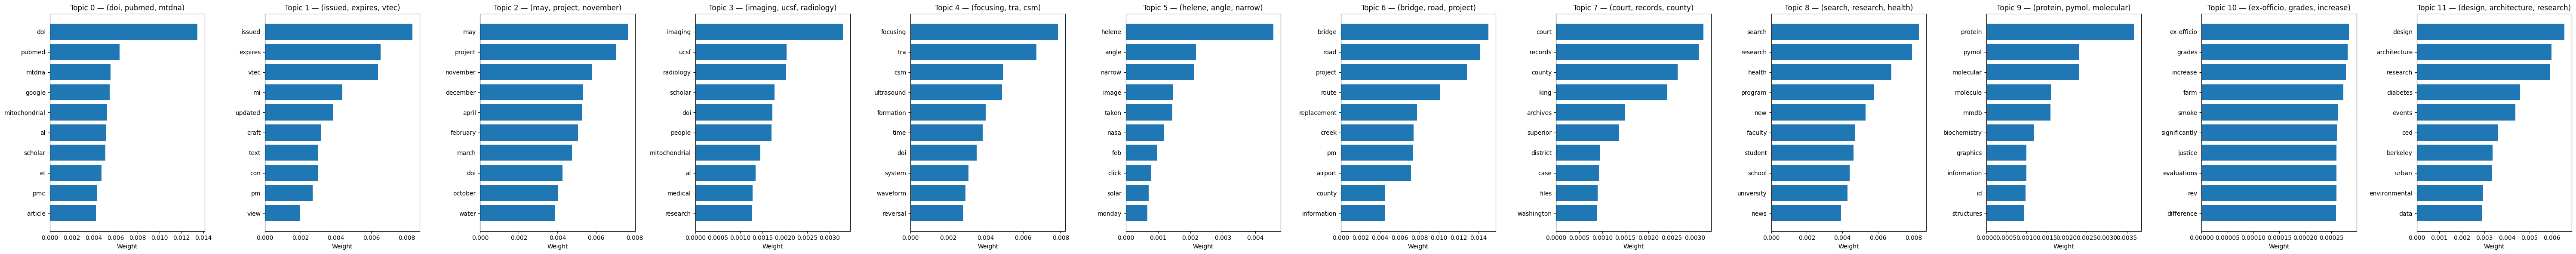

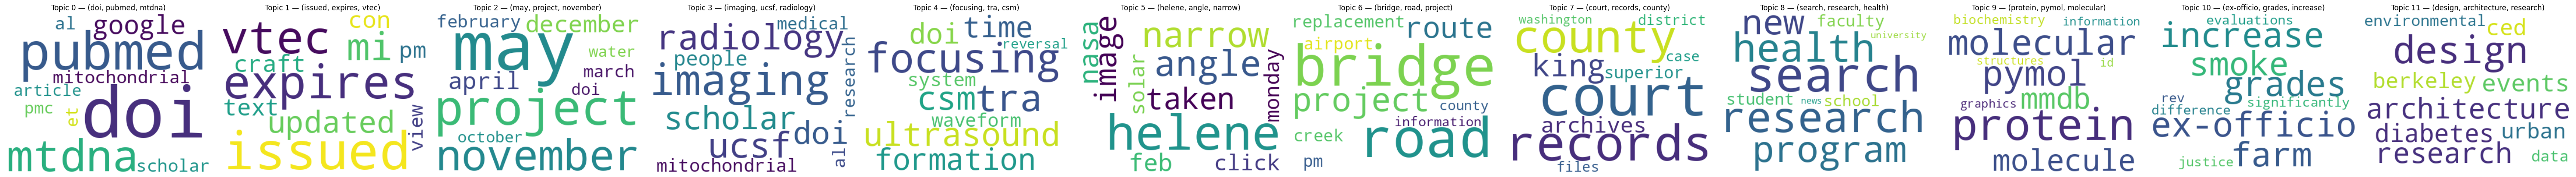

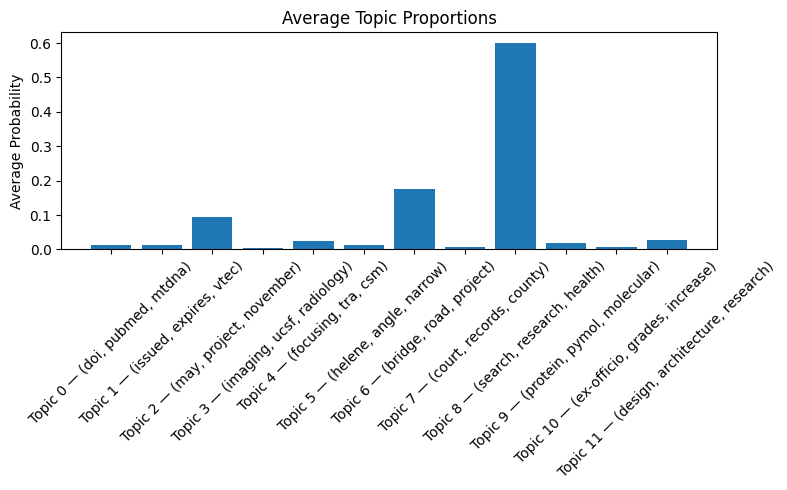

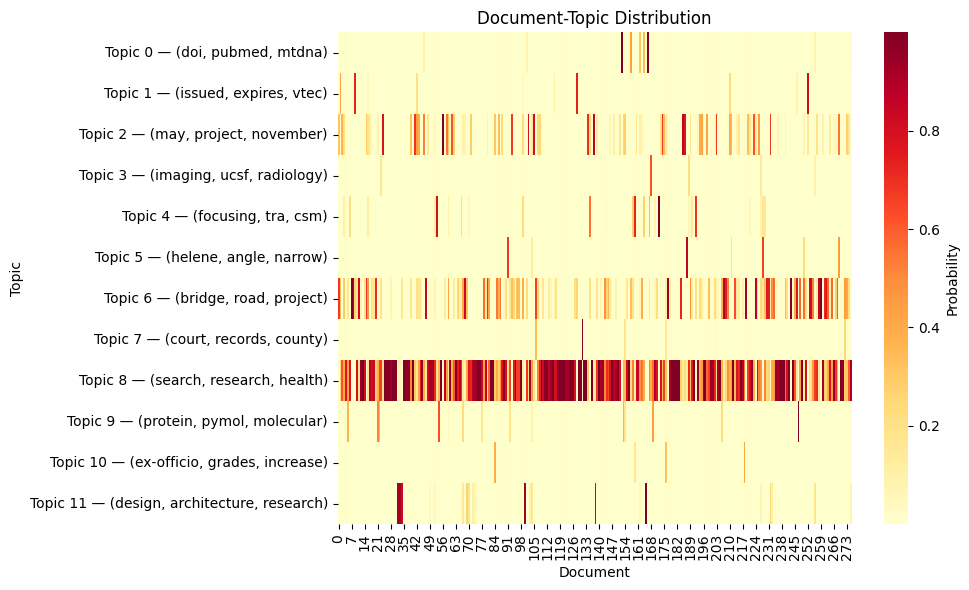

In [15]:
visualize_topics(lda_model, vocab, transformed, num_words=10)